In [2]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import os
from gql import gql
import re

In [28]:
from gql import Client
from gql.transport.aiohttp import AIOHTTPTransport
from gql.transport.httpx import HTTPXTransport


class GraphQLClient:
    def __init__(self, async_mode: bool = True):
        GRAPHQL_ENDPOINT = os.getenv(
            "GRAPHQL_ENDPOINT", "http://localhost:8080/v1/graphql"
        )
        HASURA_GRAPHQL_ADMIN_SECRET = os.getenv(
            "HASURA_GRAPHQL_ADMIN_SECRET", "superdupersecuresecret"
        )
        params = {
            "url": GRAPHQL_ENDPOINT,
            "headers": {"x-hasura-admin-secret": HASURA_GRAPHQL_ADMIN_SECRET},
        }

        if async_mode:
            transport = AIOHTTPTransport(**params)  # type: ignore
        else:
            transport = HTTPXTransport(**params)  # type: ignore

        self.client = Client(transport=transport, fetch_schema_from_transport=True)

    def getClient(self):
        return self.client


In [29]:
# Import excel file data.xlsx
products = pd.read_excel("data.xlsx", sheet_name=6)

In [30]:
products.columns

Index(['Produkt ID', 'Name', 'Eigene Produktnummer', 'Einheit'], dtype='object')

In [31]:
products.rename(columns={
    "Produkt ID": "productId",
    "Name": "name",
    "Einheit": "unit",
}, inplace=True)
products["externalArticleNumber"] = products["productId"].astype(str)
products["productId"] = products["productId"].astype(str)
products["name"] = products["name"].str.strip()
products["unit"] = products["unit"].str.strip()
products["createdAt"] = datetime.now(timezone.utc).isoformat()
products["updatedAt"] = datetime.now(timezone.utc).isoformat()
products["userId"] = "cm6p6u49o0000k9wtbwgfft3h"
products["retired"] = False
products["name"] = products["name"].str.replace(r"\s{2,}", " ", regex=True)
products.drop(columns=["Eigene Produktnummer"], inplace=True)

In [32]:
product_insert_query = gql("""
mutation MyMutation($objects: [masterdata_Product_insert_input!] = {}) {
  insert_masterdata_Product(objects: $objects, on_conflict: {constraint: Product_pkey, update_columns: name}) {
    affected_rows
  }
}
""")

client = GraphQLClient(async_mode=False).getClient()
with client as session:
    result = session.execute(
        product_insert_query,
        variable_values={"objects": products.to_dict(orient="records")},
    )
    print(result)
    print(f"Inserted {result['insert_masterdata_Product']['affected_rows']} products.")

{'insert_masterdata_Product': {'affected_rows': 2073}}
Inserted 2073 products.


In [38]:
locations_df = pd.read_excel("data.xlsx", sheet_name=5)
locations_df.rename(columns={
    "Ort ID": "locationId",
    "Name": "name",
}, inplace=True)
locations_df["locationId"] = locations_df["locationId"].astype(str)
locations_df.drop(columns=["name"], inplace=True, errors='ignore')
locations_df["createdAt"] = datetime.now(timezone.utc).isoformat()
locations_df["updatedAt"] = datetime.now(timezone.utc).isoformat() 
locations_df["userId"] = "cm6p6u49o0000k9wtbwgfft3h"

In [40]:
locations_query = gql("""
mutation MyMutation($objects: [masterdata_Location_insert_input!] = {}) {
  insert_masterdata_Location(objects: $objects, on_conflict: {constraint: Location_pkey, update_columns: userId}) {
    affected_rows
    }
}
""")

client = GraphQLClient(async_mode=False).getClient()
with client as session:
    result = session.execute(
        locations_query,
        variable_values={"objects": locations_df.to_dict(orient="records")},
    )
    print(result)
    print(f"Inserted {result['insert_masterdata_Location']['affected_rows']} locations.")


{'insert_masterdata_Location': {'affected_rows': 2}}
Inserted 2 locations.


In [41]:
# Insert assetType into database
with client as session:
    result = session.execute(
        gql("""mutation MyMutation {
            insert_masterdata_AssetType_one(object: {assetTypeId: "machine", name: "machine", isWorker: false, isStorage: false, isMultiProductStorage: false, fixedPosition: true, createdAt: "2025-08-15T14:45:00", userId: "cm6p6u49o0000k9wtbwgfft3h", sizeUnit: "kg", retired: false, updatedAt: "2025-08-15T14:45:00"}) {
              assetTypeId
            }
          }
          """))
    print(result)
    print(f"Inserted asset type: {result['insert_masterdata_AssetType_one']['assetTypeId']}.")

{'insert_masterdata_AssetType_one': {'assetTypeId': 'machine'}}
Inserted asset type: machine.


In [44]:
assets_df = pd.read_excel("data.xlsx", sheet_name=4)

In [45]:
assets_df.rename(columns={
    "Anlagen ID": "assetId",
    "Name": "name",
    "Ort": "locationId"
}, inplace=True)

assets_df["assetTypeId"] = "machine"
assets_df["assetId"] = assets_df["assetId"].astype(str)
assets_df["locationId"] = assets_df["locationId"].astype(str)
assets_df["name"] = assets_df["name"].str.strip()
assets_df["createdAt"] = datetime.now(timezone.utc).isoformat()
assets_df["updatedAt"] = datetime.now(timezone.utc).isoformat()
assets_df["userId"] = "cm6p6u49o0000k9wtbwgfft3h"
assets_df["retired"] = False
assets_df["name"] = assets_df["name"].str.replace(r"\s{2,} ", " ", regex=True)
assets_df.drop(columns=["Anlagentyp"], inplace=True, errors='ignore')

In [46]:
with client as session:
    result = session.execute(
        gql("""
        mutation MyMutation($objects: [masterdata_Asset_insert_input!] = {}) {
            insert_masterdata_Asset(objects: $objects, on_conflict: {constraint: Asset_pkey, update_columns: name}) {
                affected_rows
            }
        }
        """),
        variable_values={"objects": assets_df.to_dict(orient="records")},
    )
    print(result)
    print(f"Inserted {result['insert_masterdata_Asset']['affected_rows']} assets.")

{'insert_masterdata_Asset': {'affected_rows': 11}}
Inserted 11 assets.


In [3]:
production_orders_df = pd.read_excel("data.xlsx", sheet_name=1)
production_orders_df.rename(columns={
    "Auftragsnummer": "productionOrderId",
    "Produkt ID": "mainProductId",
    "Batchnummer": "number",
    "Menge": "actualQuantity",
    "Start": "actualStart",
    "Ende": "actualEnd",
}, inplace=True)


In [4]:
# Convert actualStart and actualEnd from YYYY-MM-DD to datetime object
def convert_to_datetime(date_str):
    if pd.isna(date_str):
        return None
    return datetime.strptime(date_str, "%Y-%m-%d").replace(tzinfo=timezone.utc)
production_orders_df["actualStart"] = production_orders_df["actualStart"].apply(convert_to_datetime)
production_orders_df["actualEnd"] = production_orders_df["actualEnd"].apply(convert_to_datetime)

# Convert datetime objects to ISO format
production_orders_df["actualStart"] = production_orders_df["actualStart"].apply(lambda x: x.isoformat() if x else None)
production_orders_df["actualEnd"] = production_orders_df["actualEnd"].apply(lambda x: x.isoformat() if x else None)
production_orders_df["productionOrderId"] = production_orders_df["productionOrderId"].astype(str)
production_orders_df["mainProductId"] = production_orders_df["mainProductId"].astype(str)
production_orders_df["number"] = production_orders_df["number"].astype(str)
production_orders_df["createdAt"] = datetime.now(timezone.utc).isoformat()
production_orders_df["updatedAt"] = datetime.now(timezone.utc).isoformat()

# delete rows with NaN in mainProductId
production_orders_df.dropna(subset=["mainProductId"], inplace=True)

# set entries with NaN in actualQuantity to 0
production_orders_df["actualQuantity"] = production_orders_df["actualQuantity"].fillna(0)

# only keep touched columns
production_orders_df = production_orders_df[[
    "productionOrderId",
    "mainProductId",
    "number",
    "actualQuantity",
    "actualStart",
    "actualEnd",
    "createdAt",
    "updatedAt"
]]



In [65]:
production_order_query = gql("""
                             mutation MyMutation($objects: [soe_state_ProductionOrder_insert_input!] = {}) {
  insert_soe_state_ProductionOrder(objects: $objects) {
    affected_rows
  }
}
""")
client = GraphQLClient(async_mode=False).getClient()

with client as session:
    result = session.execute(
        production_order_query,
        variable_values={"objects": production_orders_df.to_dict(orient="records")},
    )
    print(result)
    print(f"Inserted {result['insert_soe_state_ProductionOrder']['affected_rows']} production orders.")

{'insert_soe_state_ProductionOrder': {'affected_rows': 15550}}
Inserted 15550 production orders.


In [5]:
tasks_df = pd.read_excel("data.xlsx", sheet_name=0)
tasks_df.rename(columns={
    "Anlage": "assetId",
    "Auftrag": "processRecordId",
    "Start": "actualStart",
    "Ende": "actualEnd",
    "Zustand": "name"
}, inplace=True)


In [6]:
# Ensure both keys are of the same type (string)
tasks_df["processRecordId"] = tasks_df["processRecordId"].astype(str)
production_orders_df["productionOrderId"] = production_orders_df["productionOrderId"].astype(str)

# Join the tasks_df on the production_orders_df by processRecordId = productionOrderId
merged_production_tasks = tasks_df.merge(
    production_orders_df[["productionOrderId", "mainProductId"]],
    left_on="processRecordId",
    right_on="productionOrderId",
    how="left"
)
# count how many production_orders have no tasks
no_tasks_count = production_orders_df[~production_orders_df["productionOrderId"].isin(tasks_df["processRecordId"])]["productionOrderId"].count()
print(f"Number of production orders with no tasks: {no_tasks_count} which is {no_tasks_count / production_orders_df.shape[0] * 100:.2f}% of all production orders.")

Number of production orders with no tasks: 7468 which is 48.03% of all production orders.


In [7]:
# drop all rows where productionOrderId is NaN
merged_production_tasks.dropna(subset=["productionOrderId"], inplace=True)

# only keep rows where name = Rüsten
merged_production_tasks = merged_production_tasks[merged_production_tasks["name"] == "Rüsten"]

/var/folders/3h/frk5dq_j61j9zwx_l_2_jfnh0000gn/T/ipykernel_12206/1147315109.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


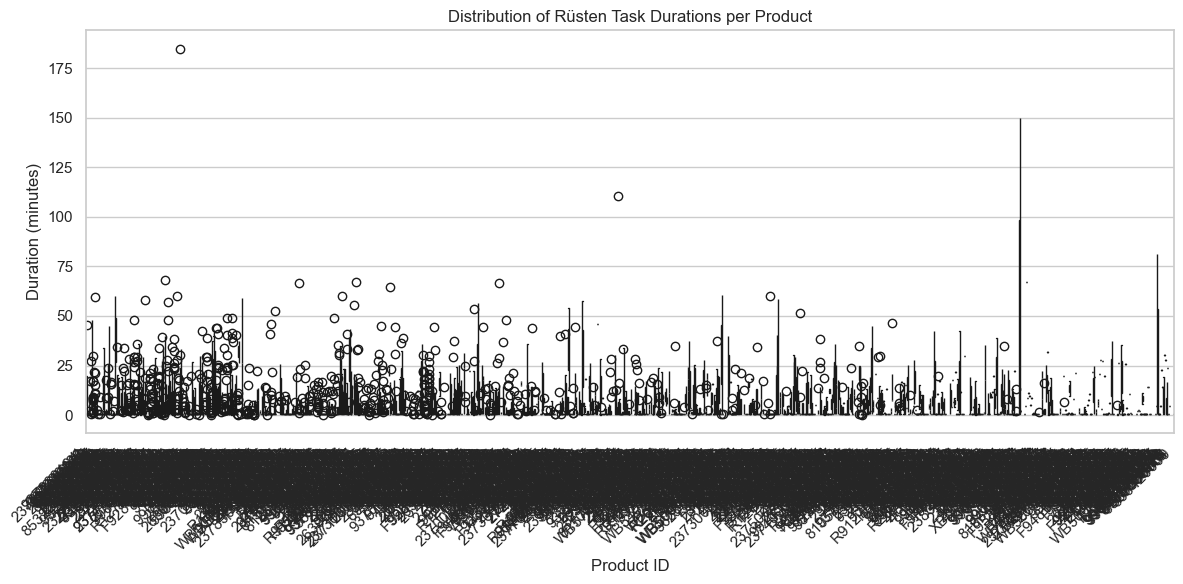

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Parse datetimes once
df = merged_production_tasks.copy()
df["actualStart"] = pd.to_datetime(df["actualStart"], errors="coerce", utc=True)
df["actualEnd"]   = pd.to_datetime(df["actualEnd"],   errors="coerce", utc=True)

# 2) Compute duration in minutes
df["duration_min"] = (df["actualEnd"] - df["actualStart"]).dt.total_seconds() / 60

# 3) Filter valid, positive durations
df = df[df["duration_min"].notna() & (df["duration_min"] >= 0)]

# Filter out outliers based on a threshold (e.g., 3 standard deviations)
threshold = df["duration_min"].mean() + 3 * df["duration_min"].std()
df = df[df["duration_min"] <= threshold]

# 4) Plot as boxplot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.boxplot(
    x="mainProductId",
    y="duration_min",
    data=df,
    palette="viridis"
)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Rüsten Task Durations per Product")
plt.xlabel("Product ID")
plt.ylabel("Duration (minutes)")
plt.tight_layout()
plt.show()

In [10]:
# Standard deviation per product
std_duration = (
    df.groupby("mainProductId", dropna=False)["duration_min"]
      .std()
      .reset_index()
      .rename(columns={"mainProductId": "productId", "duration_min": "stdDuration"})
)

print(std_duration)

            productId  stdDuration
0           015310000          NaN
1           015350000     6.142304
2       0157500001001          NaN
3           015850000     0.023570
4           015950000     7.019726
...               ...          ...
1024  WB5700-007-0015     7.412611
1025         WH5040D3     0.016667
1026         WH5100D1     4.800000
1027     XB009034KCPL          NaN
1028     XB009051KCHA          NaN

[1029 rows x 2 columns]


In [53]:
# Count how many tasks have no production order after joining them
no_production_order_tasks_count = merged_production_tasks[merged_production_tasks["productionOrderId"].isna()]["processRecordId"].count()
print(f"Number of tasks with no production order: {no_production_order_tasks_count} which is {no_production_order_tasks_count / tasks_df.shape[0] * 100:.2f}% of all tasks.")

Number of tasks with no production order: 3550 which is 6.11% of all tasks.
